Data preprocessing and splitting   

In [ ]:
#Labels are binary 1 is negative and 2 is posiitive 
import re
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize as st, word_tokenize as wt
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import SnowballStemmer


# read lexicom from csv file
df_with_links=pd.read_csv('coronavirus-tweet-id-2020-01-24-20.csv')
df_lexicon=pd.read_csv('lexicon_1.csv',encoding='ISO-8859-1')



#PREPROCESSING 

# creting 2 Dictionaries One for positive, one for negative 
dict_positive={}
dict_negative={}
sn_vocab=SnowballStemmer('english')
for key,value_positive,value_negative in zip(df_lexicon['English'],df_lexicon['Positive'],df_lexicon['Negative']):
    stemed_key=sn_vocab.stem(str(key))
    # I want to put steaned key in one colums, values in other and then remove duplicated and store it in Dictionary
    dict_positive.update({stemed_key:value_positive})
    dict_negative.update({stemed_key:value_negative})


nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
# method to remove URL's, @ and # from the text
def remove_urls_at_hash(new_list,data_column):
    for t in data_column:
        newT=re.sub('http://\S+|https://\S+','',t) #removing http/https
        no_at=re.sub('@\S+|#\S+|\n|RT|rt','',newT) # removing @,#,\n,rt
        if newT!=no_at : 
            newT=no_at
        if t==newT:
            new_list.append(t)
        elif t!=newT:
            new_list.append(newT)
        

#method to remove 1)punctuation 2)stop_words           
def text_cleaning(txt):
    cleaned_tweets=[] #list
    def hasNumbers(inputString):
      return any(char.isdigit() for char in inputString)
  
    no_dig_tweets=[]  
    temp_no_dig_tweets=[] 
    for tw_1 in txt:
      for this_word in tw_1.split():
        if not hasNumbers(this_word):
          temp_no_dig_tweets.append(this_word.lower())
        word=" ".join(temp_no_dig_tweets)
      no_dig_tweets.append(word)
      temp_no_dig_tweets=[]

    for tweet in no_dig_tweets:
        text_remove_punt=[char for char in tweet if char not in string.punctuation] #in char is not in punctuation list then return
        text_gather_chars_into_words=''.join(text_remove_punt).split()#make 1 long string and split into words
        text_remove_stop_words=[w for w in text_gather_chars_into_words if w.lower() not in stop_words] #if word not in list then  return 
        cleaned_tweets.append(text_remove_stop_words)
    return cleaned_tweets


# method to remove duplicate tweets 
def remove_duplicates(df_for_removing_duplicates):
    converting_into_set=set(df_for_removing_duplicates) # to remove duplicates from our tweets, we use set, as it contains only uniq values
    return converting_into_set

# steming STEP ONE --> stem tweets ['','','']

def stemming(tweets):
  stemed_tweets=[]
  sn=SnowballStemmer('english')
  for tweet in tweets:
    temp_tweet=[]
    line=''
    for word in tweet.split():
      temp_tweet.append(sn.stem(word))
      line=" ".join(temp_tweet)
    stemed_tweets.append(line)
  return stemed_tweets
# ANNOTATION -> LABELING 
# creting 2 Dictionaries One for positive, one for negative 
dict_positive={}
dict_negative={}
for key,value_positive,value_negative in zip(df_lexicon['English'],df_lexicon['Positive'],df_lexicon['Negative']):
    dict_positive.update({key:value_positive})
    dict_negative.update({key:value_negative})

#method for polarity retuens 2- positive, 1-negative, 0- nutral sentence sentiment 

neg_score_list=[]
pos_score_list=[]
def polarity(tweet_sentence):
    positive_score=0
    negative_score=0
    score=0
    #Labels are binary 1 is negative and 2/0 is posiitive 
    for word in str(tweet_sentence).split():
        if dict_positive.get(word)!=None:
            if dict_positive.get(word)==1:
                positive_score=positive_score+1
            if dict_negative.get(word)==1:
                negative_score=negative_score+1           
    score=positive_score-negative_score
    pos_score_list.append(positive_score)# update list with positive scored by tweet
    neg_score_list.append(negative_score)
    if score>=0: return 2 
    elif score<0: return 1

#METHOD CALLS
rem=[]   #list         
remove_urls_at_hash(new_list=rem,data_column=df_with_links['text'])
clean_data=text_cleaning(rem) # removing punctuation, stop words
#to make a from a nested list regular list
clean_data_list=[]
for ii in clean_data:
    clean_data_list.append(' '.join(ii))

no_duplicates=remove_duplicates(clean_data_list)
#call steming
stemed_tweets=stemming(no_duplicates)


# create a column of calculated polarities 
polarity_column=[] #list
for tweet in no_duplicates:
    polarity_column.append(polarity(tweet)) 

df_no_duplicate=pd.DataFrame(stemed_tweets) # casting into Data Frame, so we can use it for vectorization

#Bag of Words using CountVectorizer from sklearn

vectorizer=CountVectorizer()
x=vectorizer.fit_transform(no_duplicates)#get vocab then build vector then make an array
features_extracted=vectorizer.vocabulary_

# NEXT STEP IS TO ADD LABELING TO OUR DATASET
# 1.1 after vectorization we have as a result a matrix
matrix_to_array=x.toarray() #1.2 make matrix to array
array_to_df=pd.DataFrame(matrix_to_array)# an array to dataframe
array_to_df['label']=polarity_column # now append label to the df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Splitting the data

In [ ]:
# DEVIDE INTO TRAINING AND TESTING SET 
data_split=np.random.rand(len(array_to_df))<0.80# take true/false table to split the data, all true will go traiting , all false will fo testing data
train=array_to_df[data_split] # training set based on randomly selested values 80%
test=array_to_df[~data_split] # testing set based on 20% randomly seleted values
print(' Size of training set : ', len(train))
print(' Size of testing set : ', len(test))

# split into independednt and dependednt value for training
leng=len(train.axes[1])-1
x_train=train.iloc[:,0:leng]
y_train=train.iloc[:,leng]

# split into independednt and dependednt value for testing
x_test=test.iloc[:,0:leng]
y_test=test.iloc[:,leng]

print(array_to_df['label'].value_counts())

 Size of training set :  6280
 Size of testing set :  1466
2    5086
1    2660
Name: label, dtype: int64


**K nearest neighbor** (finding the best K)

:using matching metric is  0.7728512960436562


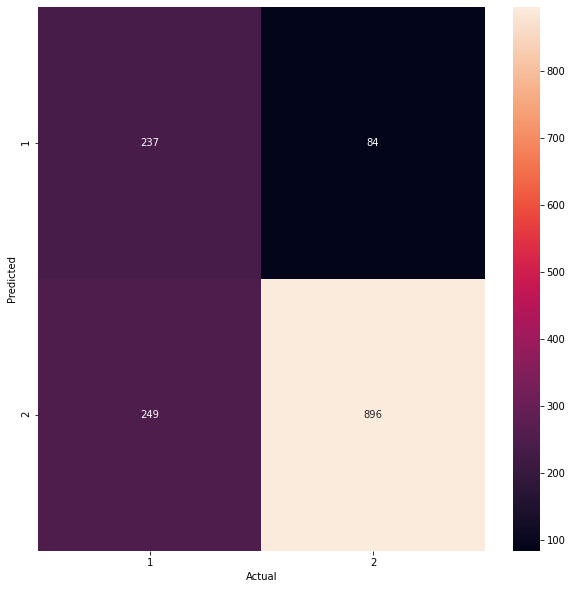

In [ ]:
#KNeighborsClassifier for binary data
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

model_one = KNeighborsClassifier(n_neighbors = 2 ,metric='matching').fit(x_train,y_train)
yhat=model_one.predict(x_test) 
print(":using matching metric is ",metrics.accuracy_score(y_test, yhat))

cm = pd.crosstab(yhat,y_test,rownames=['Predicted'], colnames=['Actual'])
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='d')

Stratified K Fold preparing data 

In [ ]:
#using Stratified K Fold to split then train for K Neighbors Classifier on BINARY data
import numpy as np
from sklearn.model_selection import StratifiedKFold
leng=len(array_to_df.axes[1])-1
X=array_to_df.iloc[:,0:leng]
y=array_to_df.iloc[:,leng]


Stratified K Fold Model  (It takes forever because of the 20 splits, reduce splits for faster calculation)

In [ ]:
from sklearn.metrics import classification_report

skf = StratifiedKFold(n_splits=20)
for train_index, test_index in skf.split(X, y):
  x_train=X.iloc[train_index,:]
  x_test=X.iloc[test_index,:]
  y_train, y_test = y[train_index], y[test_index]


  model_one = KNeighborsClassifier(n_neighbors = 2 ,metric='matching').fit(x_train,y_train)
  yhat=model_one.predict(x_test) # we use X_test to predict y_test
  print('split ',i,":using matching metric is ",metrics.accuracy_score(y_test, yhat))
  i=i+1


split  1 :using matching metric is  0.7396907216494846
split  2 :using matching metric is  0.7448453608247423
split  3 :using matching metric is  0.7963917525773195
split  4 :using matching metric is  0.729381443298969
split  5 :using matching metric is  0.7242268041237113
split  6 :using matching metric is  0.7551546391752577
split  7 :using matching metric is  0.7881136950904393
split  8 :using matching metric is  0.7855297157622739
split  9 :using matching metric is  0.7416020671834626
split  10 :using matching metric is  0.7803617571059431
split  11 :using matching metric is  0.7674418604651163
split  12 :using matching metric is  0.7571059431524548
split  13 :using matching metric is  0.751937984496124
split  14 :using matching metric is  0.7648578811369509
split  15 :using matching metric is  0.7881136950904393
split  16 :using matching metric is  0.7648578811369509
split  17 :using matching metric is  0.7493540051679587
split  18 :using matching metric is  0.772609819121447
spli

"\ncm = pd.crosstab(yhat,y_test,rownames=['Predicted'], colnames=['Actual'])\nplt.figure(figsize = (10, 10))\nsns.heatmap(cm, annot = True,fmt='d')\n\nprint(classification_report(y_test,yhat))\n"

Logistic Regression with binary data

metrics.accuracy_score :  0.8601637107776262
              precision    recall  f1-score   support

           1       0.80      0.77      0.79       486
           2       0.89      0.90      0.90       980

    accuracy                           0.86      1466
   macro avg       0.84      0.84      0.84      1466
weighted avg       0.86      0.86      0.86      1466



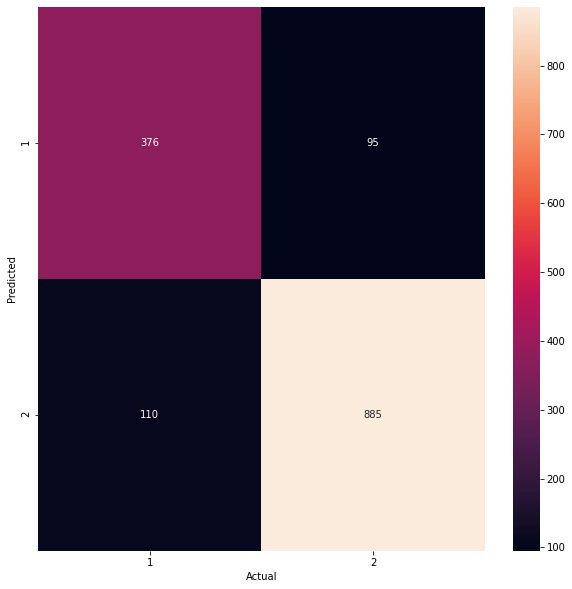

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


LR = LogisticRegression(C=0.5, solver='saga',multi_class='multinomial',class_weight='balanced',max_iter=100).fit(x_train,y_train)
yhat=LR.predict(x_test)
print('metrics.accuracy_score : ',metrics.accuracy_score(y_test,yhat ))

cm = pd.crosstab(yhat,y_test,rownames=['Predicted'], colnames=['Actual'])
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='d')
print(classification_report(y_test,yhat))


Testing has number method

In [ ]:
lower_case=['sdf 234fds  sdfsd 1234 1234  123 ds3fds3fds ','fsdfj sdfdsds gdgf3443 34323sfd 324dfs']

def hasNumbers(inputString):
  return any(char.isdigit() for char in inputString)
  
no_dig_tweets=[]  
temp_no_dig_tweets=[] 
for tw_1 in rem:
  for this_word in tw_1.split():
    if not hasNumbers(this_word):
      temp_no_dig_tweets.append(this_word)
      word=" ".join(temp_no_dig_tweets)
  no_dig_tweets.append(word)
  temp_no_dig_tweets=[]



Multinomial NB

MultinomialNB accuracy_score :  0.7830832196452933
              precision    recall  f1-score   support

           1       0.69      0.63      0.66       486
           2       0.82      0.86      0.84       980

    accuracy                           0.78      1466
   macro avg       0.76      0.74      0.75      1466
weighted avg       0.78      0.78      0.78      1466



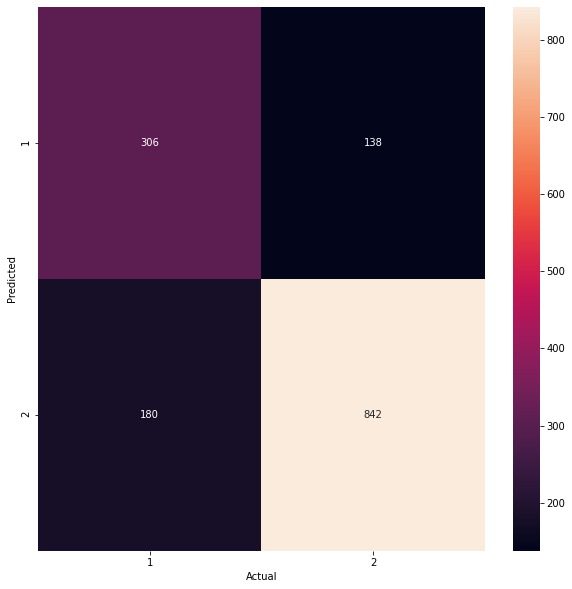

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_two = MultinomialNB(fit_prior='False').fit(x_train, y_train)
yhat = model_two.predict(x_test)
print('MultinomialNB accuracy_score : ',metrics.accuracy_score(y_test, yhat))

cm = pd.crosstab(yhat,y_test,rownames=['Predicted'], colnames=['Actual'])
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='d')
print(classification_report(y_test,yhat))



Gaussian NB

GaussianNB accuracy_score :  0.5177353342428377
              precision    recall  f1-score   support

           1       0.38      0.74      0.50       486
           2       0.76      0.41      0.53       980

    accuracy                           0.52      1466
   macro avg       0.57      0.57      0.52      1466
weighted avg       0.63      0.52      0.52      1466



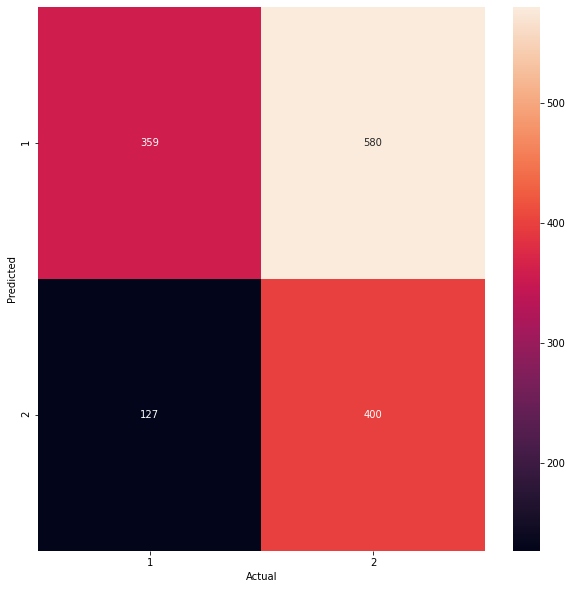

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB().fit(x_train, y_train)
yhat = model_GaussianNB.predict(x_test)
print('GaussianNB accuracy_score : ',metrics.accuracy_score(y_test, yhat))

cm = pd.crosstab(yhat,y_test,rownames=['Predicted'], colnames=['Actual'])
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='d')
print(classification_report(y_test,yhat))


Complement NB

ComplementNB accuracy_score :  0.781718963165075
              precision    recall  f1-score   support

           1       0.71      0.58      0.64       486
           2       0.81      0.88      0.84       980

    accuracy                           0.78      1466
   macro avg       0.76      0.73      0.74      1466
weighted avg       0.78      0.78      0.78      1466



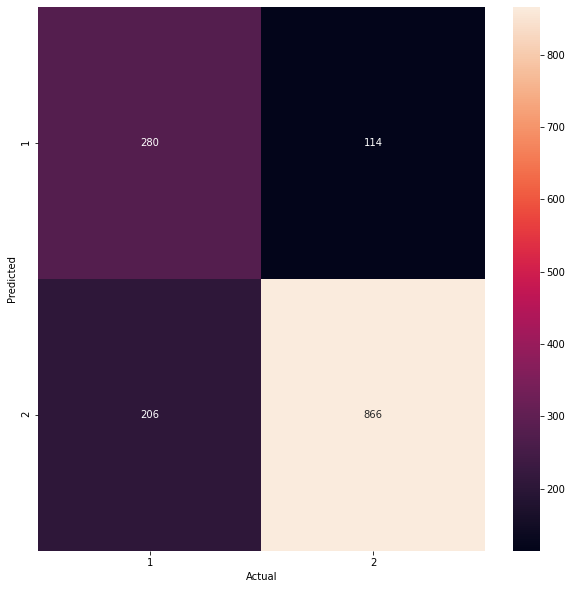

In [ ]:
from sklearn.naive_bayes import ComplementNB
model_ComplementNB = ComplementNB(norm="True").fit(x_train, y_train)
yhat = model_ComplementNB.predict(x_test)
print('ComplementNB accuracy_score : ',metrics.accuracy_score(y_test, yhat))

cm = pd.crosstab(yhat,y_test,rownames=['Predicted'], colnames=['Actual'])
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='d')
print(classification_report(y_test,yhat))
